In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
from darts import TimeSeries

df = pd.read_csv('../csv/Ming25Jun67_total_order.csv')
df.tail()

,order_completed_at,unique_order_count
536,2024-06-20,120
537,2024-06-21,152
538,2024-06-22,138
539,2024-06-23,126
540,2024-06-24,149


In [58]:
print(df.info())

df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])

# make timeseries Object
series = TimeSeries.from_dataframe(df,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                    freq="D")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_completed_at  541 non-null    object
 1   unique_order_count  541 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB
None


In [59]:
# Function to replace outliers with the mean of the rest of the values
from scipy.stats import zscore
from darts import TimeSeries

def replace_outliers_with_mean(df, column_name):
    # Calculate Z-scores
    z_scores = zscore(df[column_name])
    
    # Identify outliers (using a threshold of 3 for Z-score)
    outliers = np.abs(z_scores) > 3
    
    # Calculate mean of non-outliers
    mean_non_outliers = df.loc[~outliers, column_name].mean()
    
    # Replace outliers with the mean of non-outliers
    df.loc[outliers, column_name] = mean_non_outliers
    
    return df

# Replace outliers in 'gmv' column
df_remove_out = replace_outliers_with_mean(df, 'unique_order_count')
series_remove_outlier = TimeSeries.from_dataframe(df_remove_out,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")
series = series_remove_outlier

C:\Users\User\AppData\Local\Temp\ipykernel_26924\1351848665.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '142.47269303201506' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column_name] = mean_non_outliers


In [60]:
from darts.dataprocessing.transformers import (Scaler,)

scaler = Scaler()
series_rescaled = scaler.fit_transform(series)
series = series_rescaled

In [61]:
# training, validation =series.split_before(pd.Timestamp('2024-01-01'))
# training, validation =series.split_before(0.9)
cut_off = 0.8
training, validation =series.split_before(cut_off) # 1 month
# training, validation =series.split_before(pd.Timestamp('2024-04-01')) # 2 month

In [62]:
#check date split
validation_df = validation.pd_dataframe()
training_df = training.pd_dataframe()
print(training_df.tail())
print(validation_df.head())
print(training_df.shape)
print(validation_df.shape)

component           unique_order_count
order_completed_at                    
2024-03-03                    0.920792
2024-03-04                    0.342574
2024-03-05                    0.279208
2024-03-06                    0.388119
2024-03-07                    0.396040
component           unique_order_count
order_completed_at                    
2024-03-08                    0.358416
2024-03-09                    0.283168
2024-03-10                    0.318812
2024-03-11                    0.354455
2024-03-12                    0.368317
(432, 1)
(109, 1)


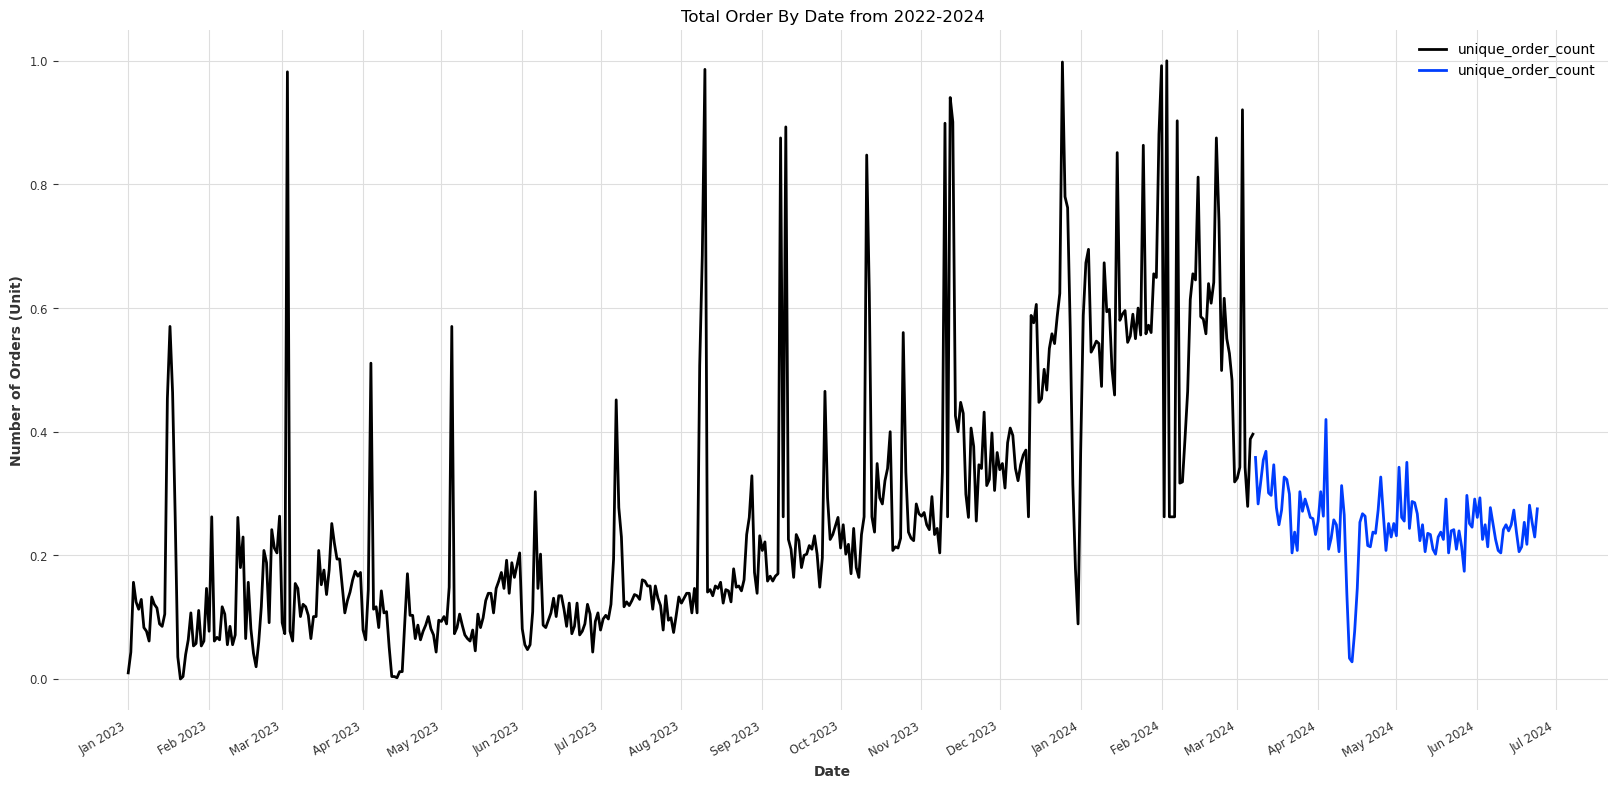

In [63]:
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
training.plot()
validation.plot()

# ตั้งค่ารูปแบบของวันที่บนแกน x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # ปรับให้วันที่ไม่ซ้อนกัน

# กำหนด Title และชื่อของแกน x และ y
plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

In [64]:
from darts.models import XGBModel
from darts.metrics import mape, mae, mse, mase
from math import sqrt

parameters = {
    "lags":list(range(1,34)),
    "output_chunk_length":  [7],  # ทดลอง output_chunk_length ที่แตกต่างกัน
    "random_state": [42]
}

best_parameter = XGBModel.gridsearch(
    parameters=parameters,
    series = series, #note (training + validation) X only training set!!!
    start=cut_off,
    forecast_horizon=7,
    stride=1,          
    last_points_only=False,  
    metric=mse,
    reduction=np.mean, 
    verbose=-1 
)

  0%|          | 0/33 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/103 [00:00<?, ?it/s]

In [70]:
print(best_parameter)
# param_dict = best_parameter[1]

(XGBModel(lags=4, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True), {'lags': 4, 'output_chunk_length': 7, 'random_state': 42}, 0.012074557104785525)


In [71]:
# best_model = best_parameter[0]
best_model = best_parameter[0]
best_model.fit(training)

XGBModel(lags=4, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True)

In [72]:
# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 120.6835
score ACC: -20.683499999999995
score MSE: 0.0711
score RMSE: 0.2667
score MAE: 0.229


In [73]:
validation_rescale = scaler.inverse_transform(validation)
prediction_rescale = scaler.inverse_transform(prediction)

mape_score = mape(validation_rescale, prediction_rescale)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation_rescale, prediction_rescale)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation_rescale, prediction_rescale)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 102.6665
score ACC: -2.666499999999999
score MSE: 18144.5144
score RMSE: 134.7016
score MAE: 115.6256


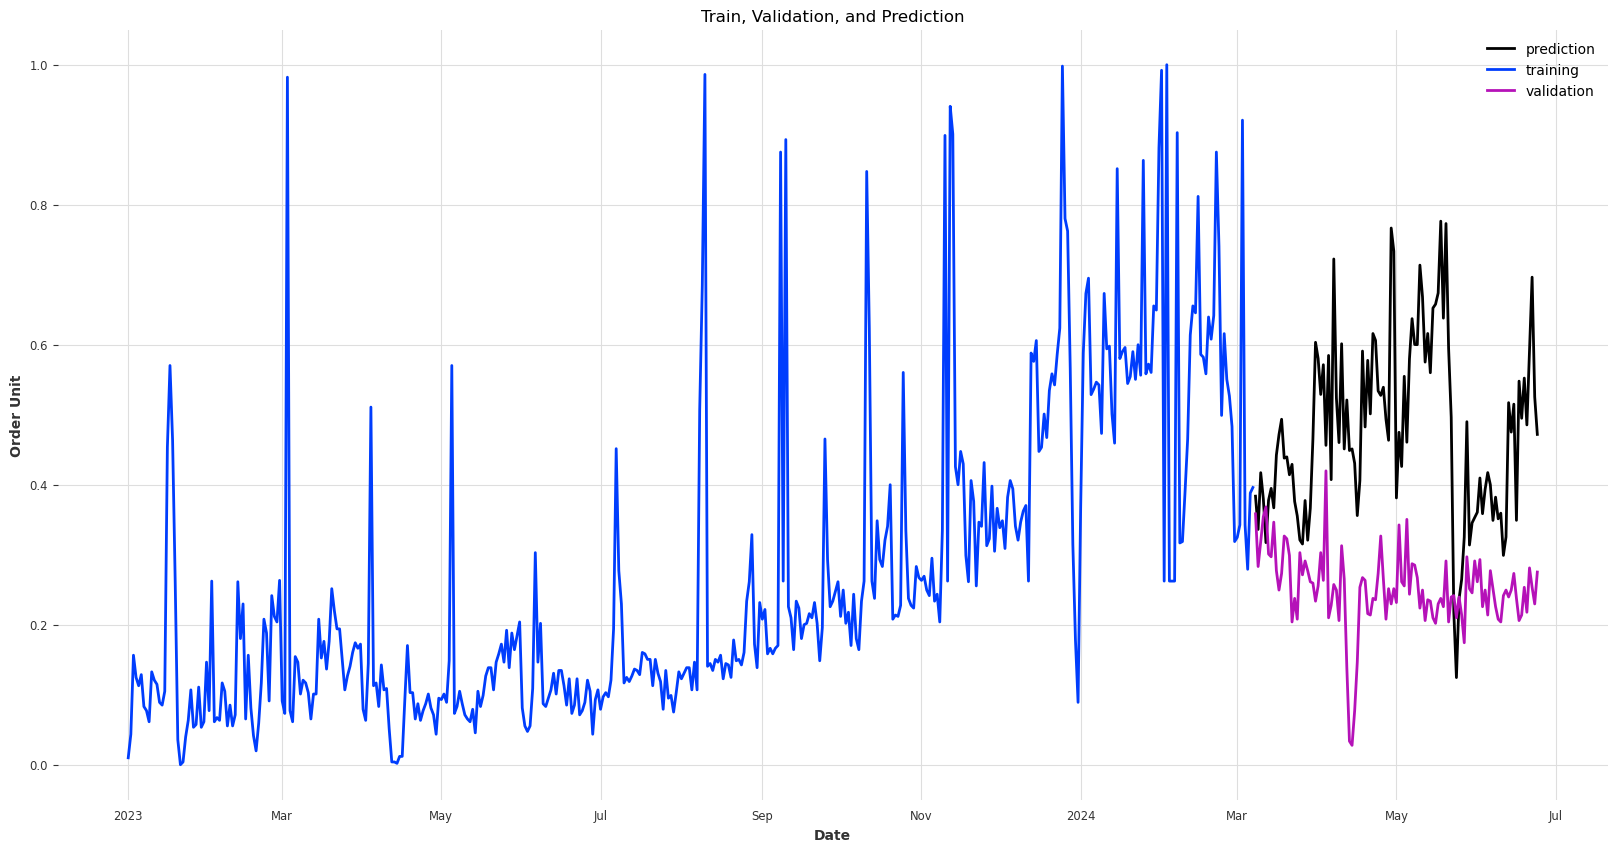

In [74]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
##prediction
prediction.plot(label="prediction")
training.plot(label="training")
validation.plot(label="validation")

plt.legend()
plt.title('Train, Validation, and Prediction')
plt.xlabel('Date')
plt.ylabel('Order Unit')
plt.show()

In [ ]:
backtest_errors = best_model.backtest(
            series,
            start=pd.Timestamp("2024-05-01"),          # เริ่มต้นที่ 90% ของข้อมูล
            forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
            stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
            last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
            metric=mape,
            reduction=np.mean,           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
            verbose=-1
        )
print(f'backtest MAPE: {backtest_errors}')

In [13]:
# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 97.1487
score ACC: 2.851299999999995
score MSE: 0.0744
score RMSE: 0.2728
score MAE: 0.2288


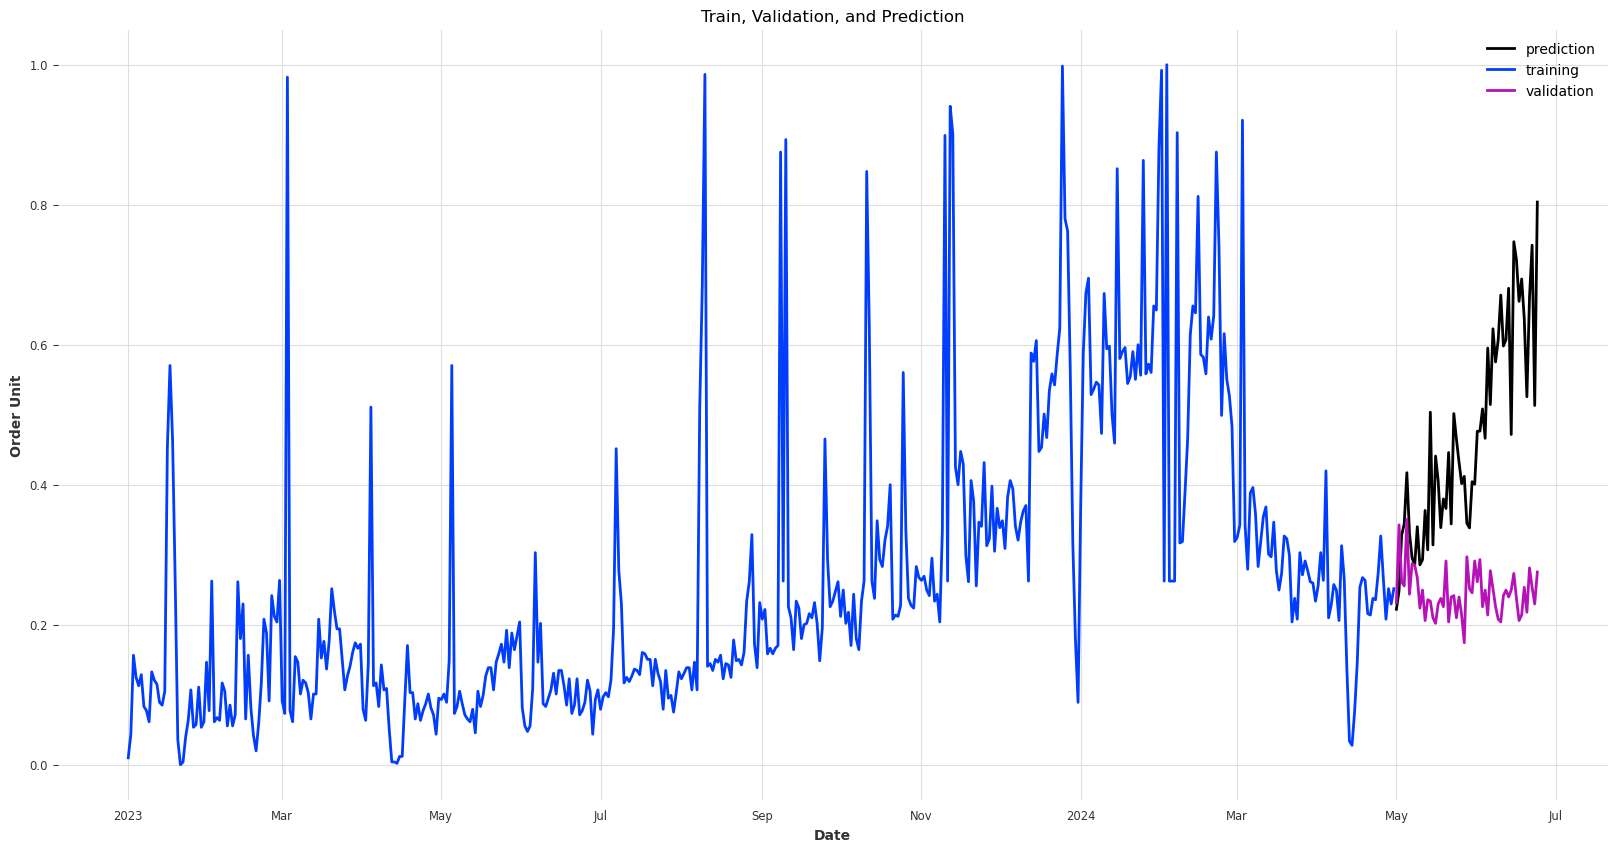

In [14]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
##prediction
prediction.plot(label="prediction")
training.plot(label="training")
validation.plot(label="validation")

plt.legend()
plt.title('Train, Validation, and Prediction')
plt.xlabel('Date')
plt.ylabel('Order Unit')
plt.show()

In [15]:
# predict future
best_model.fit(series)

XGBModel(lags=22, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True)

In [16]:
#check date
series.pd_dataframe().tail(14)

component,unique_order_count
order_completed_at,
2024-06-11,0.241584
2024-06-12,0.249505
2024-06-13,0.239604
2024-06-14,0.249505
2024-06-15,0.273267
2024-06-16,0.237624
2024-06-17,0.205941
2024-06-18,0.213861
2024-06-19,0.253465


In [17]:
forecast = best_model.predict(7)
forecast  = scaler.inverse_transform(forecast)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
print(forecast.tail(7))

forecast.to_csv('../forecast/20-25-06-67_CatBoost_31lags.csv', index=False)

        Date  Total Order
0 2024-06-25   120.499763
1 2024-06-26   151.633850
2 2024-06-27   128.344284
3 2024-06-28   140.723267
4 2024-06-29   145.636261
5 2024-06-30   128.498627
6 2024-07-01   118.312935


In [18]:
#from darts.models import LinearRegressionModel, Prophet

best_model.save("../model/XGBModel_totalOrder_25Jun67_22lags.pkl")

In [4]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt
from darts.models import XGBModel

training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 1 month

best_model = XGBModel.load("../model/XGBModel_totalOrder_25Jun67_22lags.pkl")
backtest_errors = best_model.backtest(
     series,
     start=pd.Timestamp('2024-05-01'),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mse,
     reduction=np.mean,           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
     verbose=-1
)
print(f'backtest_errors MSE: {backtest_errors}')

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/49 [00:00<?, ?it/s]

backtest_errors MSE: 2501.736541407389
